In [4]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error , r2_score

import matplotlib.pyplot as plt

In [67]:
param_grid = {
    'max_depth': [2,5,10],
    'alpha': [2,5,10],
    'learning_rate': [0.1, 0.2,0.5],
    'n_estimators': [20,50,80],
    'colsample_bytree': [0.3, 0.5,0.8]
}

In [2]:
df_final = pd.read_csv('../Data/df_final.csv', index_col="time")

In [123]:
df_final_pre = pd.read_csv('../Data/df_final_pre.csv', index_col="time")

In [3]:
def prep_split(df, columns_drop, label, train_end_date, hours_ahead):
    # Add a column with the label shifted by "hours" rows

    if hours_ahead == 0:
        df['label_shifted'] = df[label]
    else:
        df['label_shifted'] = df[label].shift(-hours_ahead)
        # Drop the last "hours" rows as they have no label values
        df = df.iloc[:-hours_ahead]
   
    
    def split_by_date(X, train_end_date):
        if not isinstance(train_end_date, pd.Timestamp):
            train_end_date = pd.Timestamp(train_end_date)

        # Convert index of X and y to Timestamp objects if they are strings
        if isinstance(X.index[0], str):
            X.index = pd.to_datetime(X.index)

        X_train = X[X.index <= train_end_date]
        X_test = X[X.index > train_end_date]

        return X_train, X_test

    X = df.drop(columns=columns_drop + ['label_shifted'])
    y = df['label_shifted']

    X_train, X_test = split_by_date(X, train_end_date)
    y_train, y_test = split_by_date(y, train_end_date)

    # Standardize all columns except target
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)

    X_test_scaled = scaler.transform(X_test)
    X_test = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

    return X_train, X_test, y_train, y_test

In [153]:
X_train, X_test, y_train, y_test = prep_split(df_final, 
                                               columns_drop=[], 
                                               label='price actual', 
                                               train_end_date='2015-12-31 23:00:00+00:00',
                                               hours_ahead=3)

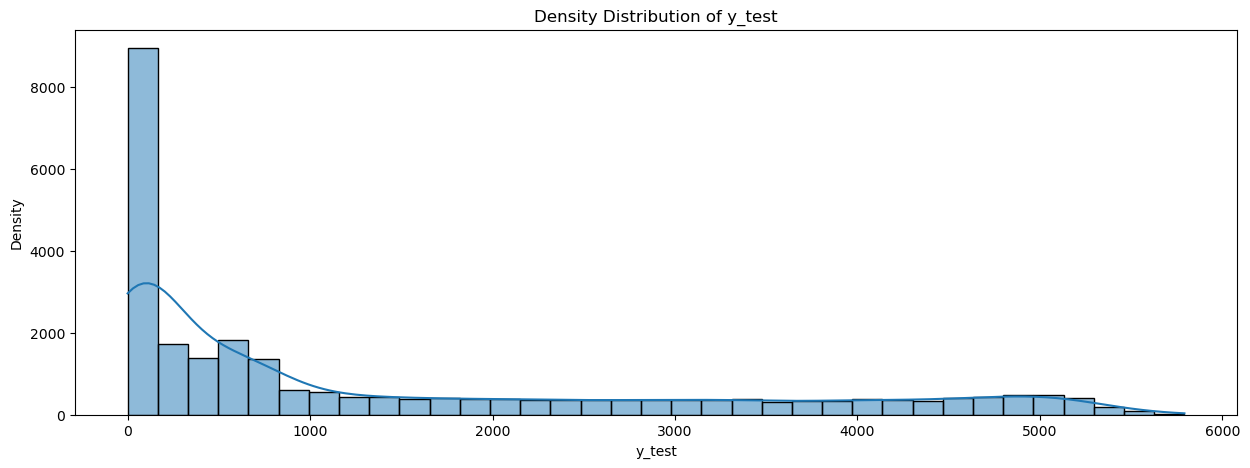

In [88]:
import seaborn as sns
plt.figure(figsize=(15, 5))
sns.histplot(y_test, kde=True)
plt.xlabel('y_test')
plt.ylabel('Density')
plt.title('Density Distribution of y_test')
plt.show()

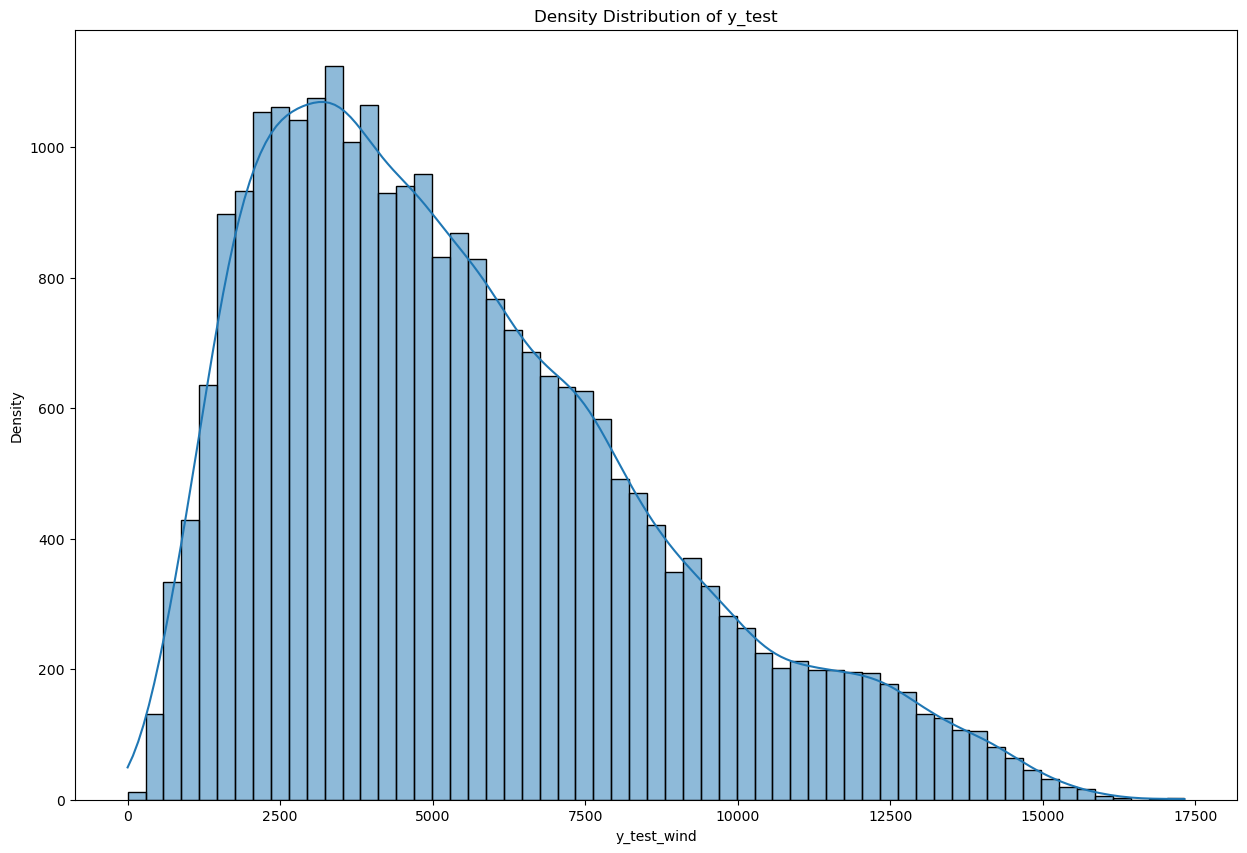

In [89]:
import seaborn as sns
plt.figure(figsize=(15, 10))
sns.histplot(y_test_wind, kde=True)
plt.xlabel('y_test_wind')
plt.ylabel('Density')
plt.title('Density Distribution of y_test')
plt.show()

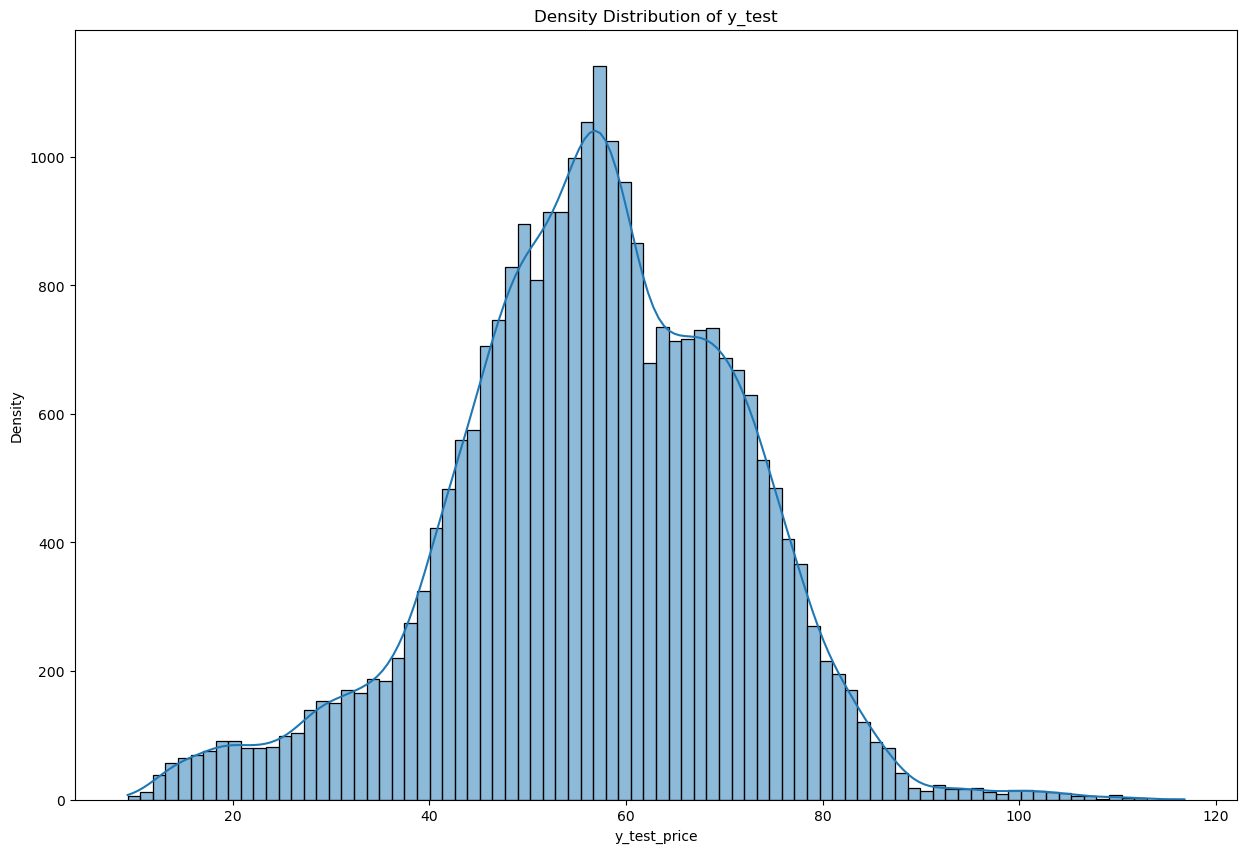

In [99]:
import seaborn as sns
plt.figure(figsize=(15, 10))
sns.histplot(y_test_price, kde=True)
plt.xlabel('y_test_price')
plt.ylabel('Density')
plt.title('Density Distribution of y_test')
plt.show()

In [232]:
def XGB(X_train, X_test, y_train, y_test, param_grid, scoring='neg_mean_squared_error', random_state=None):
    # Initialize and train the XGBoost classifier
    xg_reg = XGBRegressor(objective='reg:squarederror', random_state=random_state)

    # Perform GridSearchCV
    grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, scoring=scoring, cv=5, verbose=1)
    grid_search.fit(X_train, y_train)

    # Print best parameters found by GridSearchCV
    best_params = grid_search.best_params_
    print("Best parameters:", best_params)

    # Re-train the model with the best parameters on the full training set
    xgb_optimized = XGBRegressor(**best_params, use_label_encoder=False, objective = 'reg:squarederror', random_state=random_state)
    xgb_optimized.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred_optimized = xgb_optimized.predict(X_test)
    #allow only bigger then zero
    y_pred_optimized[y_pred_optimized < 0] = 0

    y_pred=pd.DataFrame(y_pred_optimized)

    # Calculate and print the scoring on the test set
    scoring_value = neg_mean_squared_error(y_test, y_pred)
    print("Test set {} with optimized parameters: {:.4f}".format(scoring, scoring_value))
    
    return xgb_optimized,y_pred, best_params, scoring_value

In [283]:
X_train, X_test, y_train, y_test = prep_split(df_final, 
                                               columns_drop=[], 
                                               label='generation solar', 
                                               train_end_date='2017-12-31 23:00:00+00:00',
                                               hours_ahead=3)

In [284]:
# Example usage
param_grid = {
    'max_depth': [10],
    'alpha': [10],
    'learning_rate': [0.1],
    'n_estimators': [100],
    'colsample_bytree': [0.8]
}


xgb_optimized, y_pred, best_params, MSE = XGB(X_train, X_test, y_train, y_test, param_grid, scoring='neg_mean_squared_error', random_state=42)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'alpha': 10, 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}


NameError: name 'neg_mean_squared_error' is not defined

In [201]:
y_test.describe()

count    8756.000000
mean     1373.219050
std      1658.258611
min         2.000000
25%        52.000000
50%       560.000000
75%      2439.500000
max      5792.000000
Name: label_shifted, dtype: float64

In [211]:
y_pred.describe()

,0
count,8756.000000
mean,1418.401123
std,1535.058350
min,-38.554081
25%,188.413731
50%,649.465240
75%,2461.582458
max,5480.082031


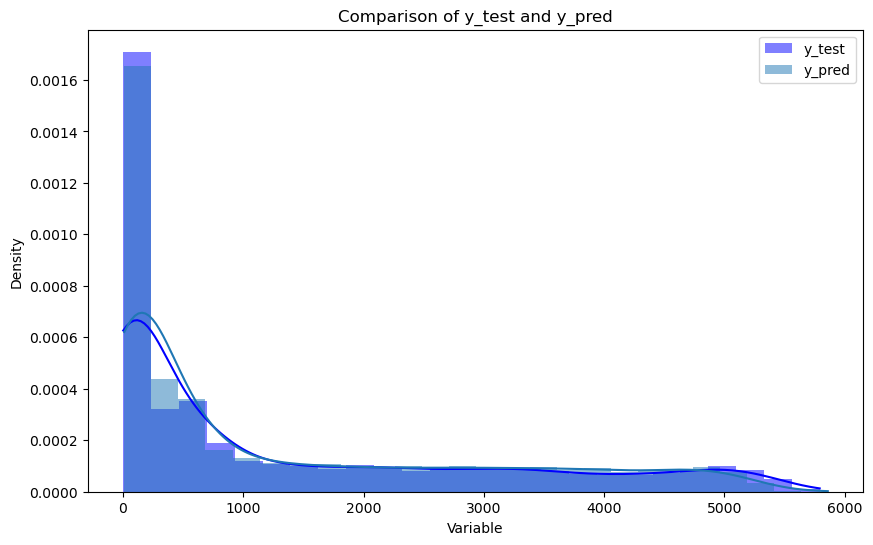

In [245]:
plt.figure(figsize=(10, 6))

# Plotting the distribution of df1
sns.histplot(y_test, color="blue", label='y_test', kde=True, stat="density", linewidth=0)
# Plotting the distribution of df2
sns.histplot(y_pred, color="red", label='y_pred', kde=True, stat="density", linewidth=0)
# Add labels and legend
plt.title('Comparison of y_test and y_pred')
plt.xlabel('Variable')
plt.ylabel('Density')
plt.legend()

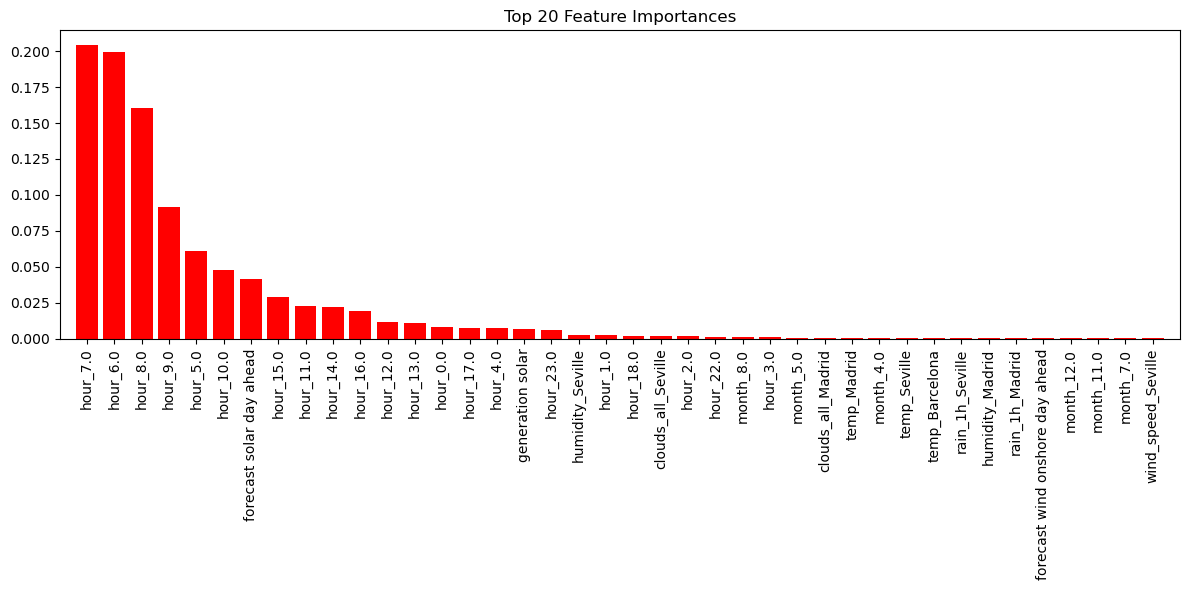

In [222]:
importances = xgb_optimized.feature_importances_
indices = np.argsort(importances)[::-1][:40]  # Select top 20 most important features
plt.figure(figsize=(12, 6))  # Increase width of the plot
plt.title('Top 20 Feature Importances')
plt.bar(range(len(indices)), importances[indices], color='r', align='center')
plt.xticks(range(len(indices)), X_train.columns[indices], rotation=90)
plt.xlim([-1, len(indices)])
plt.tight_layout()  # Adjust layout for better readability
plt.show()

In [8]:
# Initialize the DataFrame to store model information
models_run = pd.DataFrame(columns=['model', 'param', 'optimizer', 'loss_function', 'MSE', 'MAE', 'RMSE', 'MAPE'])

In [11]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def XGB_flex(X_train, X_test, y_train, y_test, param_grid, objective, scoring, random_state=42):
    # Initialize the XGBoost regressor with a basic configuration
    xg_reg = XGBRegressor(objective=objective, random_state=random_state)
    
    # Perform GridSearchCV
    grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, scoring=scoring, cv=5, verbose=1)
    grid_search.fit(X_train, y_train)
    
    # Best parameters from GridSearchCV
    best_params = grid_search.best_params_
    
    # Re-train the model with the best parameters on the full training set
    xgb_optimized = XGBRegressor(**best_params, objective=objective, random_state=random_state)
    xgb_optimized.fit(X_train, y_train, verbose=1)
    
    # Make predictions on the test set
    y_pred_optimized = xgb_optimized.predict(X_test)
    y_pred_optimized = np.maximum(0, y_pred_optimized)  # Ensuring no negative predictions
    
    # Prepare predictions for output
    y_pred = pd.DataFrame(y_pred_optimized, columns=['Predictions'])
    
    # Calculate the scoring metric on the test set
    mse_value = mean_squared_error(y_test, y_pred)
    mae_value = mean_absolute_error(y_test, y_pred)
    rmse_value = np.sqrt(mse_value)
    mape_value = mean_absolute_percentage_error(y_test, y_pred)

    
    # Store model information in a DataFrame
    model_info = {
        'model': str(XGB_flex),
        'param':a [best_params],
        'optimizer': [objective],
        'random_state': [random_state],
        'MSE': [mse_value],
        'MAE': [mae_value],
        'RMSE': [rmse_value],
        'MAPE': [mape_value],
    }
    
    return xgb_optimized, y_pred, model_info


In [297]:
xgb_optimized, y_pred, model_info = XGB_flex(X_train, X_test, y_train, y_test, param_grid, objective='reg:tweedie', scoring='neg_mean_squared_error', random_state=42)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [336]:
from datetime import datetime

def save_models_run(models):
    # Generate timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # File name with timestamp
    file_name = f"models_run_{timestamp}.csv"
    
    # Save DataFrame to CSV
    models.to_csv(file_name, index=False)
    
    print(f"models_run DataFrame saved to {file_name}")

In [337]:
# Call the function to save models_run DataFrame
save_models_run(models_run)

models_run DataFrame saved to models_run_20240423_140109.csv


In [12]:
# Initialize models_run DataFrame
models_xgb = pd.DataFrame(columns=['model', 'param', 'optimizer', 'scoring', 'random_state', 
                                    'MSE', 'MAE', 'RMSE', 'MAPE', 'label', 'hour'])

# Define parameter grid
param_grid = {
    'max_depth': [5,10],
    'alpha': [5,10],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100,120],
    'colsample_bytree': [0.8,0.9]
}

objectives = [
    'reg:squarederror',
    #'reg:squaredlogerror',
    #'reg:pseudohubererror',
    'reg:tweedie',
    #'reg:absoluteerror',
    #'reg:quantileerror'
]
scorings = [
    #'explained_variance',
    'neg_mean_squared_error',
    #'neg_mean_absolute_error',
    #'neg_root_mean_squared_error',
    #'neg_mean_squared_log_error',
    #'neg_mean_absolute_percentage_error',
]

# List of hours and labels
hours = [1,3,6,12]  
labels = ['generation solar', 'generation wind onshore', 'price actual'] 

for hour in hours:
    for label in labels:
        # Prepare data
        X_train, X_test, y_train, y_test = prep_split(df_final, 
                                                       columns_drop=[], 
                                                       label=label, 
                                                       train_end_date='2017-12-31 23:00:00+00:00',
                                                       hours_ahead=hour)
        
        # Run XGB_flex for all combinations
        for objective, scoring in itertools.product(objectives, scorings):
            xgb_optimized, y_pred, model_info= XGB_flex(X_train, X_test, y_train, y_test, param_grid, objective=objective, scoring=scoring, random_state=42)
        # Add current label and hour to models_run DataFrame
        model_info['label'] = label
        model_info['hour'] = hour
        models_xgb = pd.concat([models_xgb, pd.DataFrame(model_info)], ignore_index=True)


Fitting 5 folds for each of 32 candidates, totalling 160 fits


NameError: name 'a' is not defined

In [1]:
models_xgb

NameError: name 'models_xgb' is not defined

In [ ]:
# DATA CLEANING 


# Step 1: Import the necessary libraries
import pandas as pd
import numpy as np
from sklearn import preprocessing

# Step 2: Load the dataset
df = pd.read_csv('df.csv')

# Step 3: Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

# Step 4: Handle missing values
# Example: Fill missing values with mean for numerical columns
# numerical_cols = df.select_dtypes(include=[np.number]).columns
# df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

# Example: Fill missing values with mode for categorical columns
# categorical_cols = df.select_dtypes(include=[np.object]).columns
# df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

# Step 5: Check for duplicates
duplicates = df.duplicated().sum()
print("Duplicate Rows:", duplicates)
df.drop_duplicates(inplace=True)

# Step 6: Convert data types
# Example: Convert 'Date' column to datetime
# df['Date'] = pd.to_datetime(df['Date'])
# Example: Convert 'Category' column to categorical
# df['Category'] = df['Category'].astype('category')

# Step 7: Handle outliers
# Example: Identify and handle outliers in 'Price' column using IQR method
# Q1 = df['Price'].quantile(0.25)
# Q3 = df['Price'].quantile(0.75)
# IQR = Q3 - Q1
# df = df[~((df['Price'] < (Q1 - 1.5 * IQR)) | (df['Price'] > (Q3 + 1.5 * IQR)))]

# Step 8: Normalize/Scale data
# Example: Normalize 'Price' column using Min-Max scaling
# scaler = preprocessing.MinMaxScaler()
# df[['Price']] = scaler.fit_transform(df[['Price']])

# Step 9: Feature Engineering
# Example: Create a new feature 'Revenue' by multiplying 'Price' and 'Quantity'
# df['Revenue'] = df['Price'] * df['Quantity']
# Example: Extracting year and month from the 'Date' column
# df['Year'] = pd.to_datetime(df['Date']).dt.year
# df['Month'] = pd.to_datetime(df['Date']).dt.month

# Step 10: Export cleaned data
df.to_csv('cleaned_df.csv', index=False)
